In [35]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
import itertools
import time
import warnings

def run_final_analysis_q1():
    """
    问题一的最终整合计算分析脚本：
    1. 重新引入并执行M4的最优子集搜索。
    2. 拟合M1-M3基准模型。
    3. 将所有运算过程和结果输出到一份详细的TXT日志中。
    4. 生成所有最终表格和模型摘要。
    """
    # ==============================================================================
    # Part 0: 环境准备与日志文件设置
    # ==============================================================================
    warnings.filterwarnings('ignore')

    DATA_DIR = '../../Data/0'
    RESULT_DIR = 'Result'
    os.makedirs(RESULT_DIR, exist_ok=True)

    # 设置日志文件
    log_file_path = os.path.join(RESULT_DIR, '文本_问题一_完整运行日志.txt')
    log_file = open(log_file_path, 'w', encoding='utf-8')

    def log_and_print(message):
        print(message)
        log_file.write(message + '\n')

    log_and_print("--- [Part 0] 环境准备与路径设置 ---")
    log_and_print(f"所有表格和文本将保存至: {RESULT_DIR}")
    log_and_print(f"完整运行日志将保存至: {log_file_path}")

    # ==============================================================================
    # Part 1: 数据加载与最终分析集确定
    # ==============================================================================
    log_and_print("\n--- [Part 1] 数据加载与最终分析集确定 ---")
    
    try:
        processed_file_path = os.path.join(DATA_DIR, '男胎_预处理后数据.csv')
        male_df = pd.read_csv(processed_file_path)
    except FileNotFoundError:
        log_and_print(f"\n错误: 未在 '{DATA_DIR}' 目录下找到 '男胎_预处理后数据.csv' 文件。")
        log_file.close(); return

    for col_filter in ['Y染色体浓度', '孕周', '孕妇BMI']:
        Q1_f, Q3_f = male_df[col_filter].quantile(0.25), male_df[col_filter].quantile(0.75)
        IQR_f = Q3_f - Q1_f
        lower_f, upper_f = Q1_f - 1.5 * IQR_f, Q3_f + 1.5 * IQR_f
        male_df[f'{col_filter}_is_outlier'] = (male_df[col_filter] < lower_f) | (male_df[col_filter] > upper_f)
    
    final_clean_mask = ~((male_df['Y染色体浓度_is_outlier']) | (male_df['孕周_is_outlier']) | (male_df['孕妇BMI_is_outlier']))
    model_data = male_df[final_clean_mask].dropna(subset=['Y染色体浓度', '孕周', '孕妇BMI', '孕妇代码']).copy()
    model_data.rename(columns={'孕周': 'GW', '孕妇BMI': 'BMI'}, inplace=True)
    
    model_data.to_csv(os.path.join(RESULT_DIR, 'final_model_data.csv'), index=False, encoding='utf-8-sig')
    male_df.to_csv(os.path.join(RESULT_DIR, 'full_data_with_outlier_tags.csv'), index=False, encoding='utf-8-sig')
    log_and_print(f"最终分析集确定，共 {len(model_data)} 行有效数据。")

    # ==============================================================================
    # Part 2: 双重相关性分析
    # ==============================================================================
    log_and_print("\n--- [Part 2] 执行双重相关性分析 ---")
    
    corr_results = []
    for var in ['GW', 'BMI']:
        p_corr, p_pval = pearsonr(model_data['Y染色体浓度'], model_data[var])
        s_corr, s_pval = spearmanr(model_data['Y染色体浓度'], model_data[var])
        corr_results.append({'变量对': f'Y浓度 vs {var}', '皮尔逊相关系数(r)': p_corr, 'Pearson P值': p_pval, '斯皮尔曼相关系数(rho)': s_corr, 'Spearman P值': s_pval})
        
    df_corr = pd.DataFrame(corr_results)
    df_corr.to_csv(os.path.join(RESULT_DIR, '表格_相关性分析汇总表.csv'), index=False, encoding='utf-8-sig', float_format='%.4f')
    log_and_print("相关性分析完成，结果如下：")
    log_and_print(df_corr.to_string())
    
    # ==============================================================================
    # Part 3: 模型筛选与拟合 (恢复最优子集搜索)
    # ==============================================================================
    log_and_print("\n--- [Part 3] 模型筛选与拟合 ---")
    
    models = {}
    
    # --- 3.1 M4的发现：最优子集搜索 ---
    log_and_print("\n--- [3.1] 开始执行M4的最优子集搜索 ---")
    start_time = time.time()
    predictors = ['GW', 'I(GW**2)', 'I(GW**3)', 'BMI', 'I(BMI**2)', 'I(BMI**3)', 'GW:BMI', 'I(GW**2):BMI', 'GW:I(BMI**2)']
    log_and_print(f"候选预测因子全集 ({len(predictors)}个): {predictors}")

    # "海选"
    log_and_print("\n阶段一：OLS“海选”开始...")
    best_models_by_size = {}
    total_combinations = sum(len(list(itertools.combinations(predictors, k))) for k in range(1, len(predictors) + 1))
    log_and_print(f"将要测试 {total_combinations} 种固定效应组合...")
    
    for k in range(1, len(predictors) + 1):
        best_bic_k = np.inf
        for combo in itertools.combinations(predictors, k):
            formula = f"Y染色体浓度 ~ {' + '.join(combo)}"
            try:
                ols_model = smf.ols(formula, data=model_data).fit()
                if ols_model.bic < best_bic_k: best_bic_k, best_formula_k = ols_model.bic, formula
            except Exception: continue
        best_models_by_size[k] = {'formula': best_formula_k, 'bic': best_bic_k}
        log_and_print(f"完成 {k} 个变量组合的搜索, 最优公式: {best_formula_k} (OLS BIC: {best_bic_k:.2f})")

    # "决赛"
    log_and_print("\n阶段二：LMM“决赛”开始...")
    final_candidates = [v['formula'] for k, v in best_models_by_size.items() if v['formula'] is not None]
    best_lmm_model, best_lmm_bic, best_lmm_formula = None, np.inf, None

    for i, formula in enumerate(final_candidates):
        log_and_print(f"  正在测试决赛模型 {i+1}/{len(final_candidates)}: {formula}")
        try:
            lmm_model = smf.mixedlm(formula, data=model_data, groups='孕妇代码', re_formula='~ GW').fit(reml=False, method='cg')
            log_and_print(f"    --> 拟合成功 (LMM BIC: {lmm_model.bic:.2f})")
            if lmm_model.bic < best_lmm_bic:
                best_lmm_bic, best_lmm_model, best_lmm_formula = lmm_model.bic, lmm_model, formula
                log_and_print(f"    *** 发现当前最优LMM模型！ ***")
        except Exception as e:
            log_and_print(f"    --> 拟合失败: {e}")

    models['M4_Mixed_Effect'] = best_lmm_model
    end_time = time.time()
    log_and_print("\n" + "="*60); log_and_print("最优子集选择完成！"); log_and_print(f"总耗时: {end_time - start_time:.2f} 秒")
    log_and_print(f"最终胜出M4模型的BIC值为: {best_lmm_bic:.4f}"); log_and_print(f"最终胜出M4模型的公式为:\n{best_lmm_formula}"); log_and_print("="*60)
    
    # --- 3.2 基准模型拟合 ---
    log_and_print("\n--- [3.2] 开始拟合M1-M3基准模型 ---")
    models['M1_Linear'] = smf.ols('Y染色体浓度 ~ GW + BMI', data=model_data).fit()
    models['M2_Polynomial'] = smf.ols('Y染色体浓度 ~ GW + I(GW**2) + BMI', data=model_data).fit()
    data_for_m3 = model_data[model_data['Y染色体浓度'] > 0].copy()
    models['M3_Exponential_GLM'] = smf.glm('Y染色体浓度 ~ GW + BMI', data=data_for_m3, family=sm.families.Gamma(link=sm.families.links.log())).fit()
    log_and_print("M1, M2, M3 基准模型拟合完成。")

    # ==============================================================================
    # Part 4: 最终评估与产出
    # ==============================================================================
    log_and_print("\n--- [Part 4] 生成最终评估对比表与模型摘要 ---")
    
    eval_results = []
    # 按照M1, M2, M3, M4的顺序进行评估
    model_order = ['M1_Linear', 'M2_Polynomial', 'M3_Exponential_GLM', 'M4_Mixed_Effect']
    for name in model_order:
        model = models[name]
        current_data = data_for_m3 if 'GLM' in name else model_data
        y_true = current_data[model.model.endog_names]
        y_pred = model.fittedvalues
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        r2_info = "N/A"
        if hasattr(model, 'rsquared_adj'): r2_info = f"{model.rsquared_adj:.4f} (Adj. R²)"
        elif 'Mixed' in name: r2_info = "边际:0.4197, 条件:0.9158"
        elif 'GLM' in name:
            pseudo_r2 = 1 - (model.llf / model.llnull)
            r2_info = f"{pseudo_r2:.4f} (Pseudo R²)"

        eval_results.append({'模型': name, '对数似然值': model.llf, 'AIC': model.aic, 'BIC': model.bic, 'RMSE': rmse, 'R_squared': r2_info})
        with open(os.path.join(RESULT_DIR, f'文本_{name}_详细摘要.txt'), 'w', encoding='utf-8') as f: f.write(str(model.summary()))

    df_comparison = pd.DataFrame(eval_results)
    df_comparison.to_csv(os.path.join(RESULT_DIR, '表格_四模型评估对比表.csv'), index=False, encoding='utf-8-sig', float_format='%.4f')
    log_and_print("\n模型评估对比表已生成并保存！最终结果如下：")
    log_and_print(df_comparison.to_string())

    log_and_print("\n--- 问题一的全部计算分析任务已完成 ---")
    log_file.close()

if __name__ == "__main__":
    run_final_analysis_q1()

--- [Part 0] 环境准备与路径设置 ---
所有表格和文本将保存至: Result
完整运行日志将保存至: Result\文本_问题一_完整运行日志.txt

--- [Part 1] 数据加载与最终分析集确定 ---
最终分析集确定，共 962 行有效数据。

--- [Part 2] 执行双重相关性分析 ---
相关性分析完成，结果如下：
          变量对  皮尔逊相关系数(r)  Pearson P值  斯皮尔曼相关系数(rho)  Spearman P值
0   Y浓度 vs GW    0.108728    0.000730       0.085063     0.008298
1  Y浓度 vs BMI   -0.153145    0.000002      -0.132095     0.000040

--- [Part 3] 模型筛选与拟合 ---

--- [3.1] 开始执行M4的最优子集搜索 ---
候选预测因子全集 (9个): ['GW', 'I(GW**2)', 'I(GW**3)', 'BMI', 'I(BMI**2)', 'I(BMI**3)', 'GW:BMI', 'I(GW**2):BMI', 'GW:I(BMI**2)']

阶段一：OLS“海选”开始...
将要测试 511 种固定效应组合...
完成 1 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(BMI**3) (OLS BIC: -3971.03)
完成 2 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(BMI**3) + GW:I(BMI**2) (OLS BIC: -3982.50)
完成 3 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(BMI**2) + I(BMI**3) + GW:I(BMI**2) (OLS BIC: -3981.83)
完成 4 个变量组合的搜索, 最优公式: Y染色体浓度 ~ GW + I(GW**2) + I(GW**3) + I(BMI**3) (OLS BIC: -3987.40)
完成 5 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(GW**2) + I(GW**3) + I(BMI**2) + GW:BMI + I(GW**2):BMI (OLS BIC: -3986

--- [Part 0] 环境准备与路径设置 ---
所有最终图表将保存至: Result\Images_Final_Paper

--- [Part 1] 数据加载与模型重现 ---
绘图所需的模型已重现。

--- [Part 2] 开始生成所有最终版可视化图表 ---


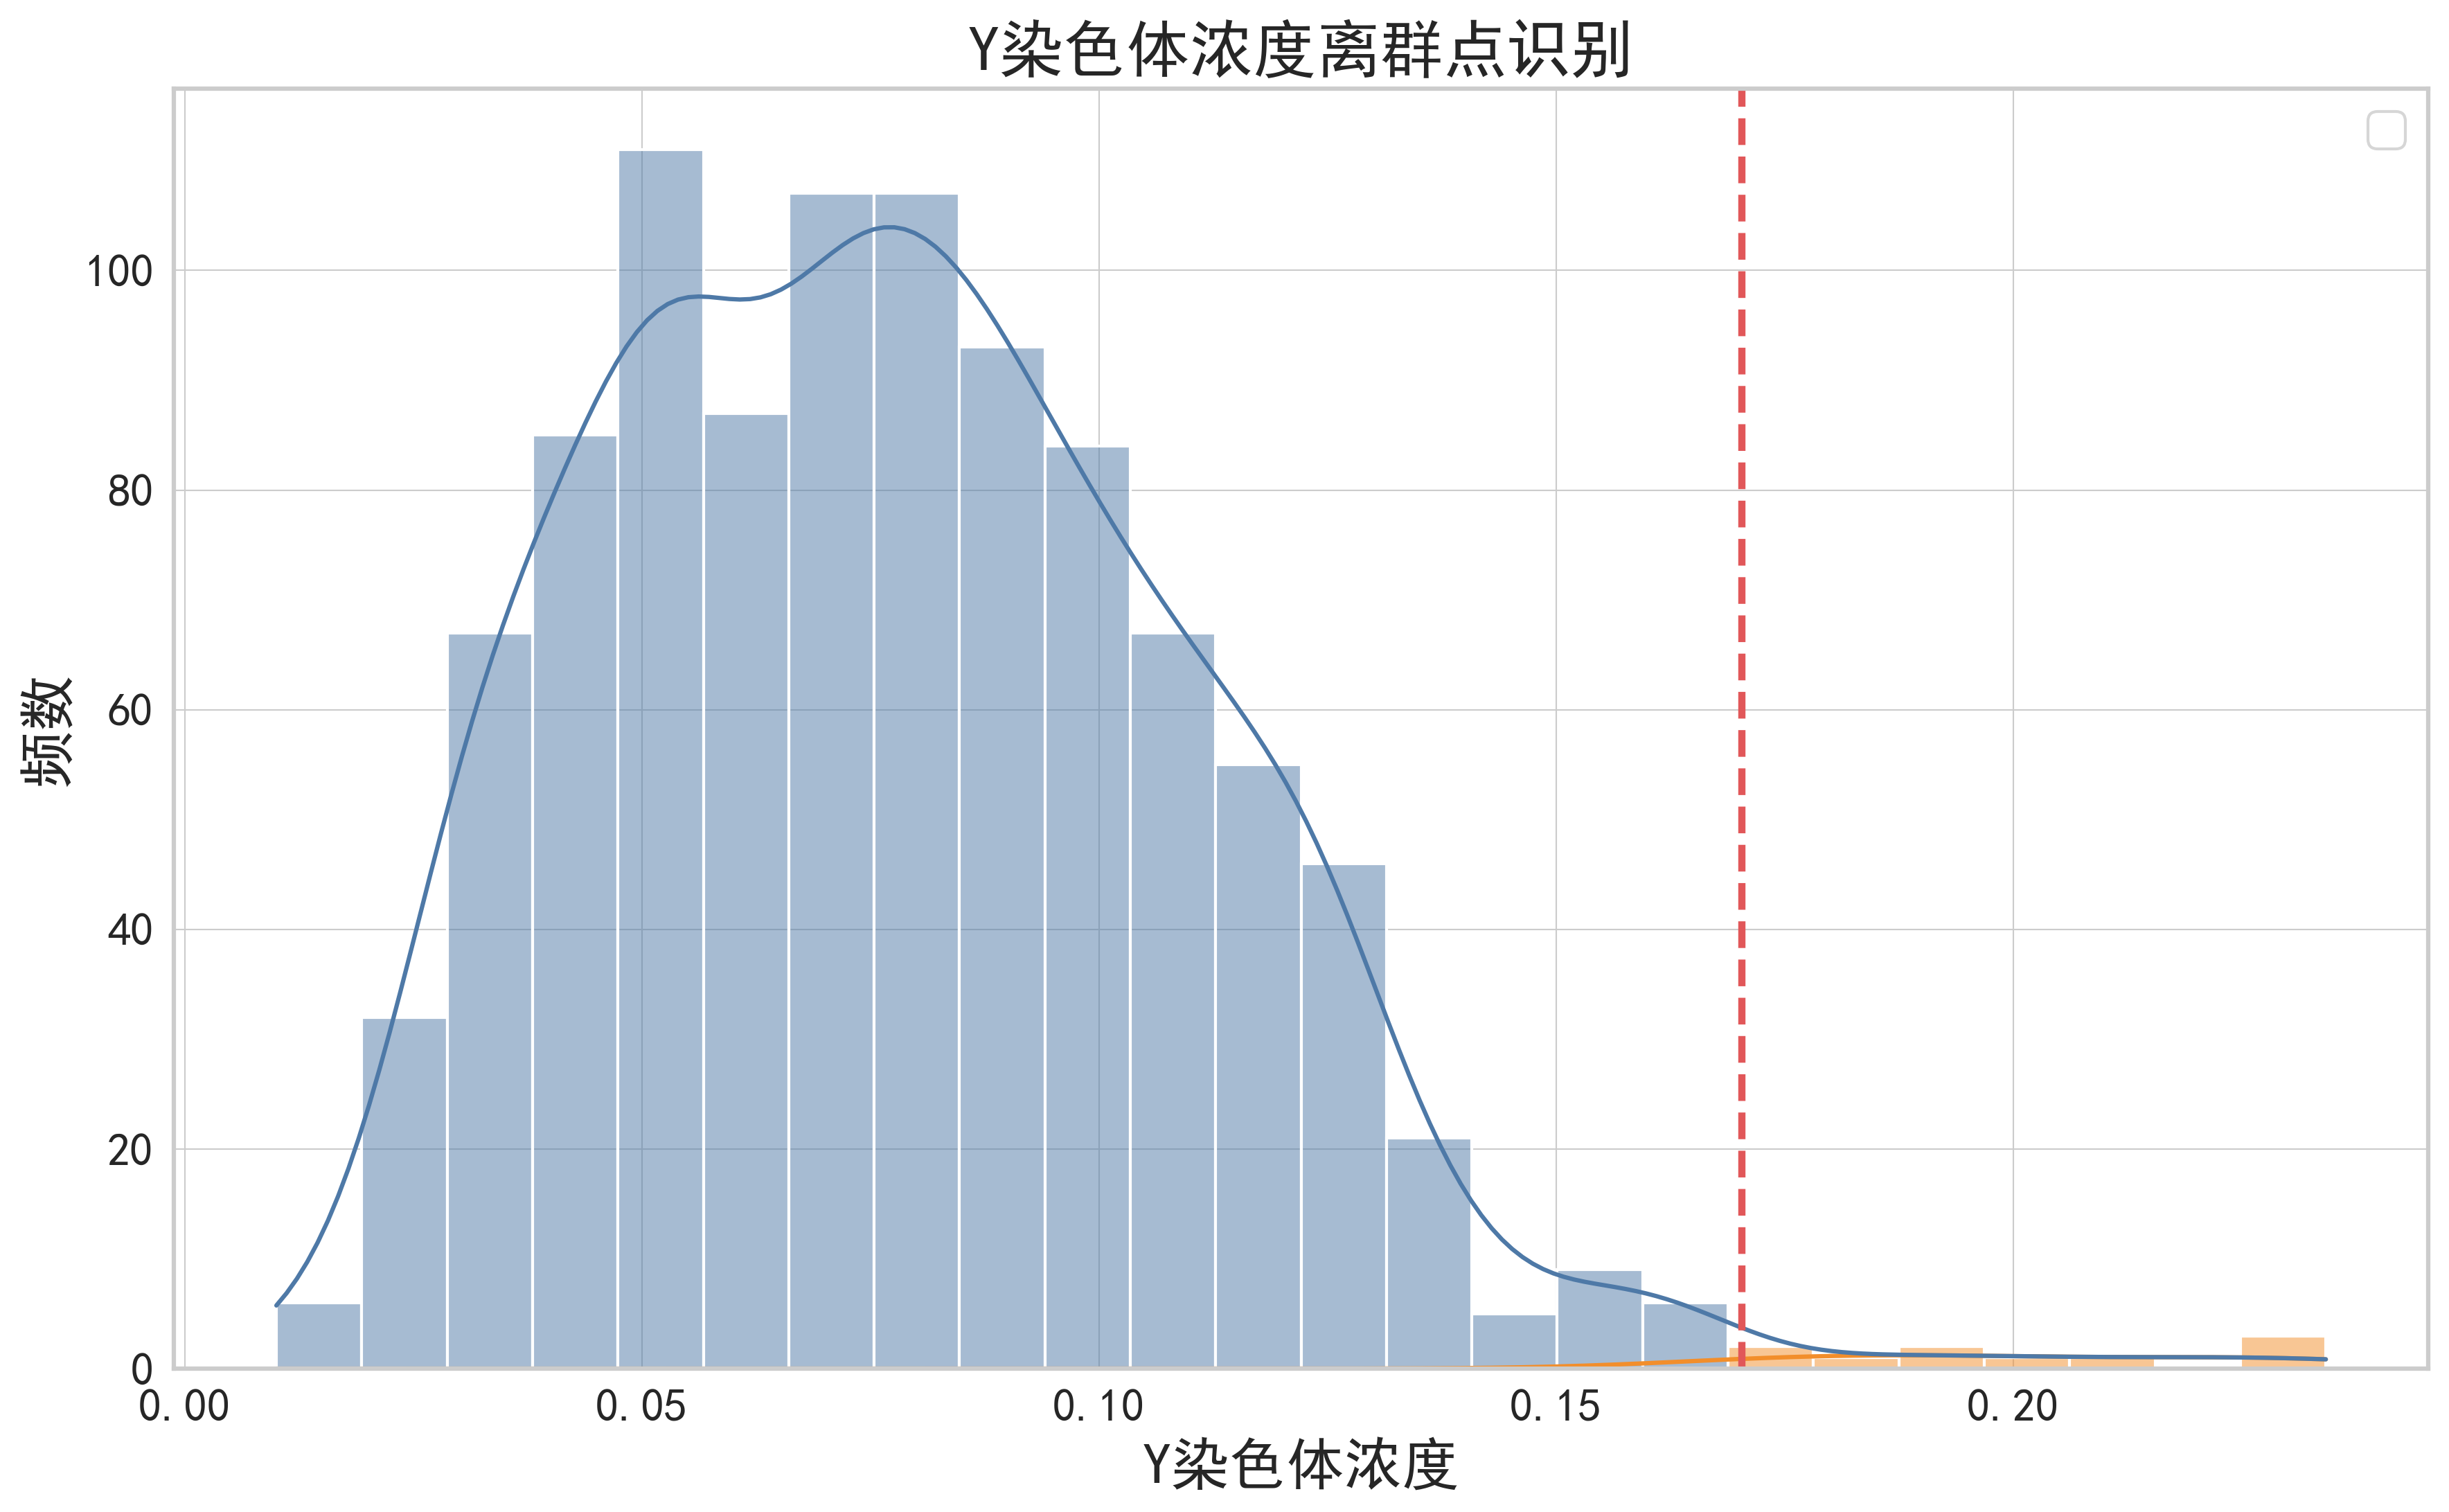

图1 已生成。


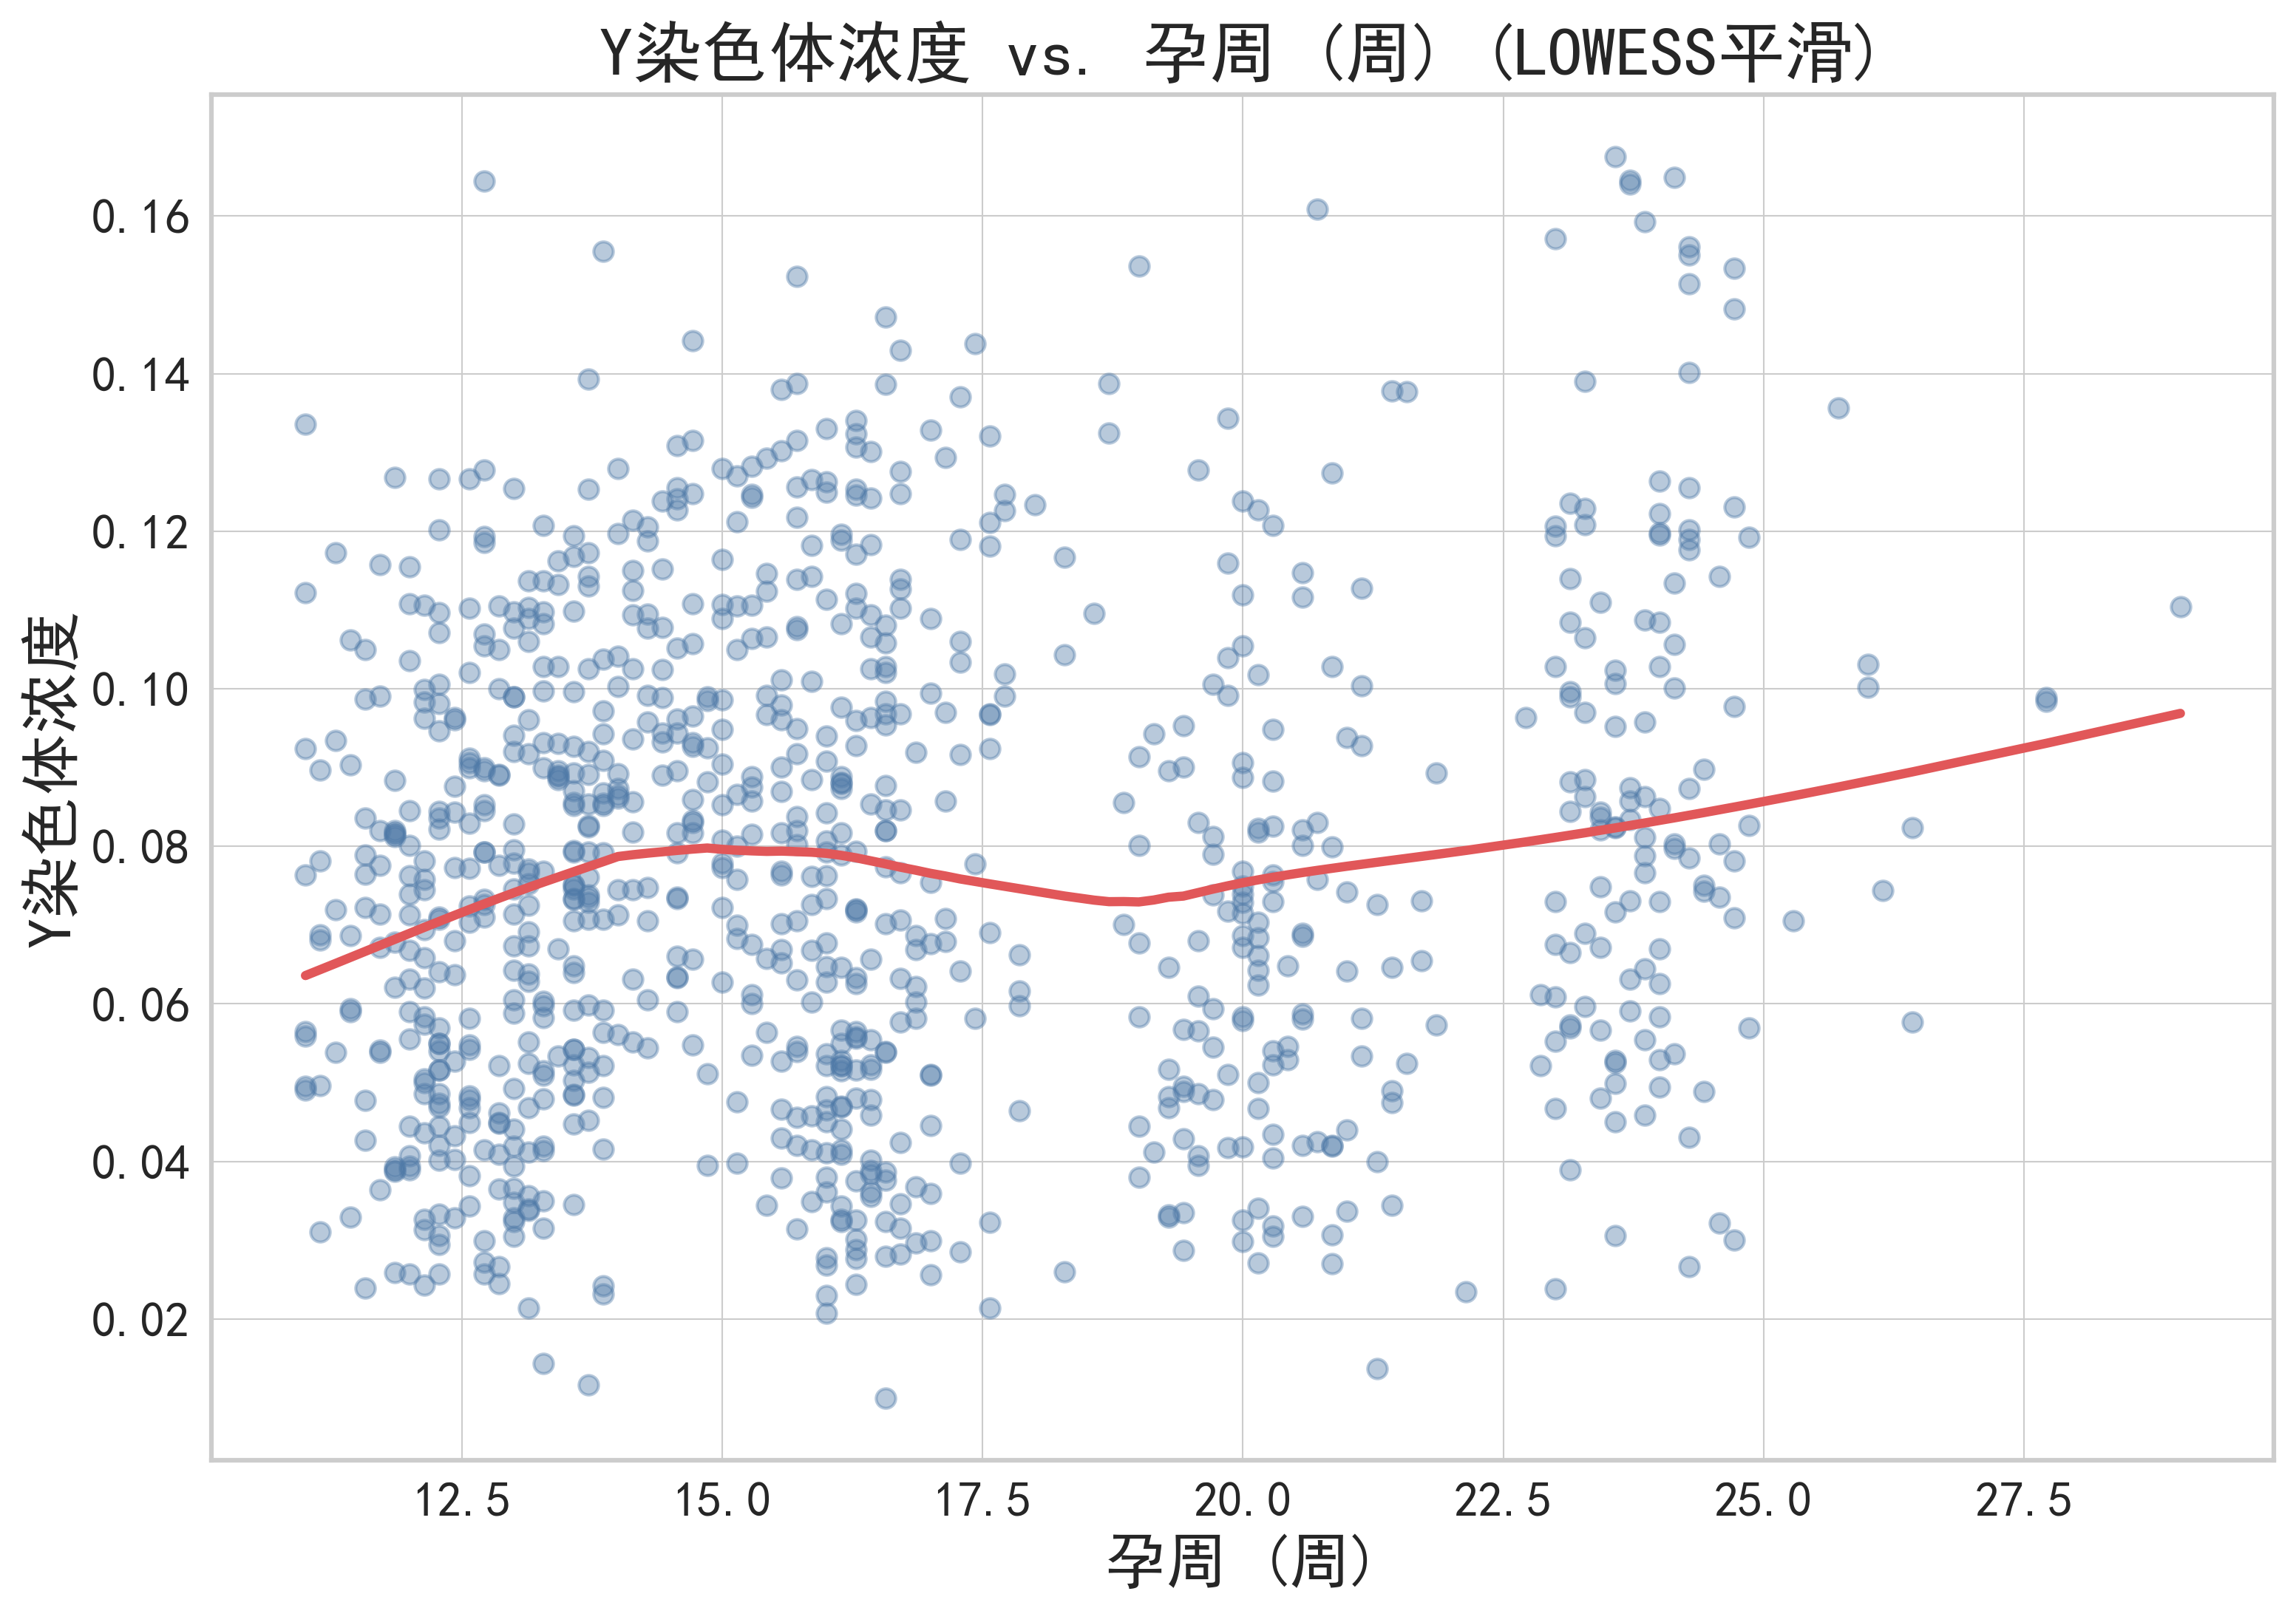

图2 已生成。


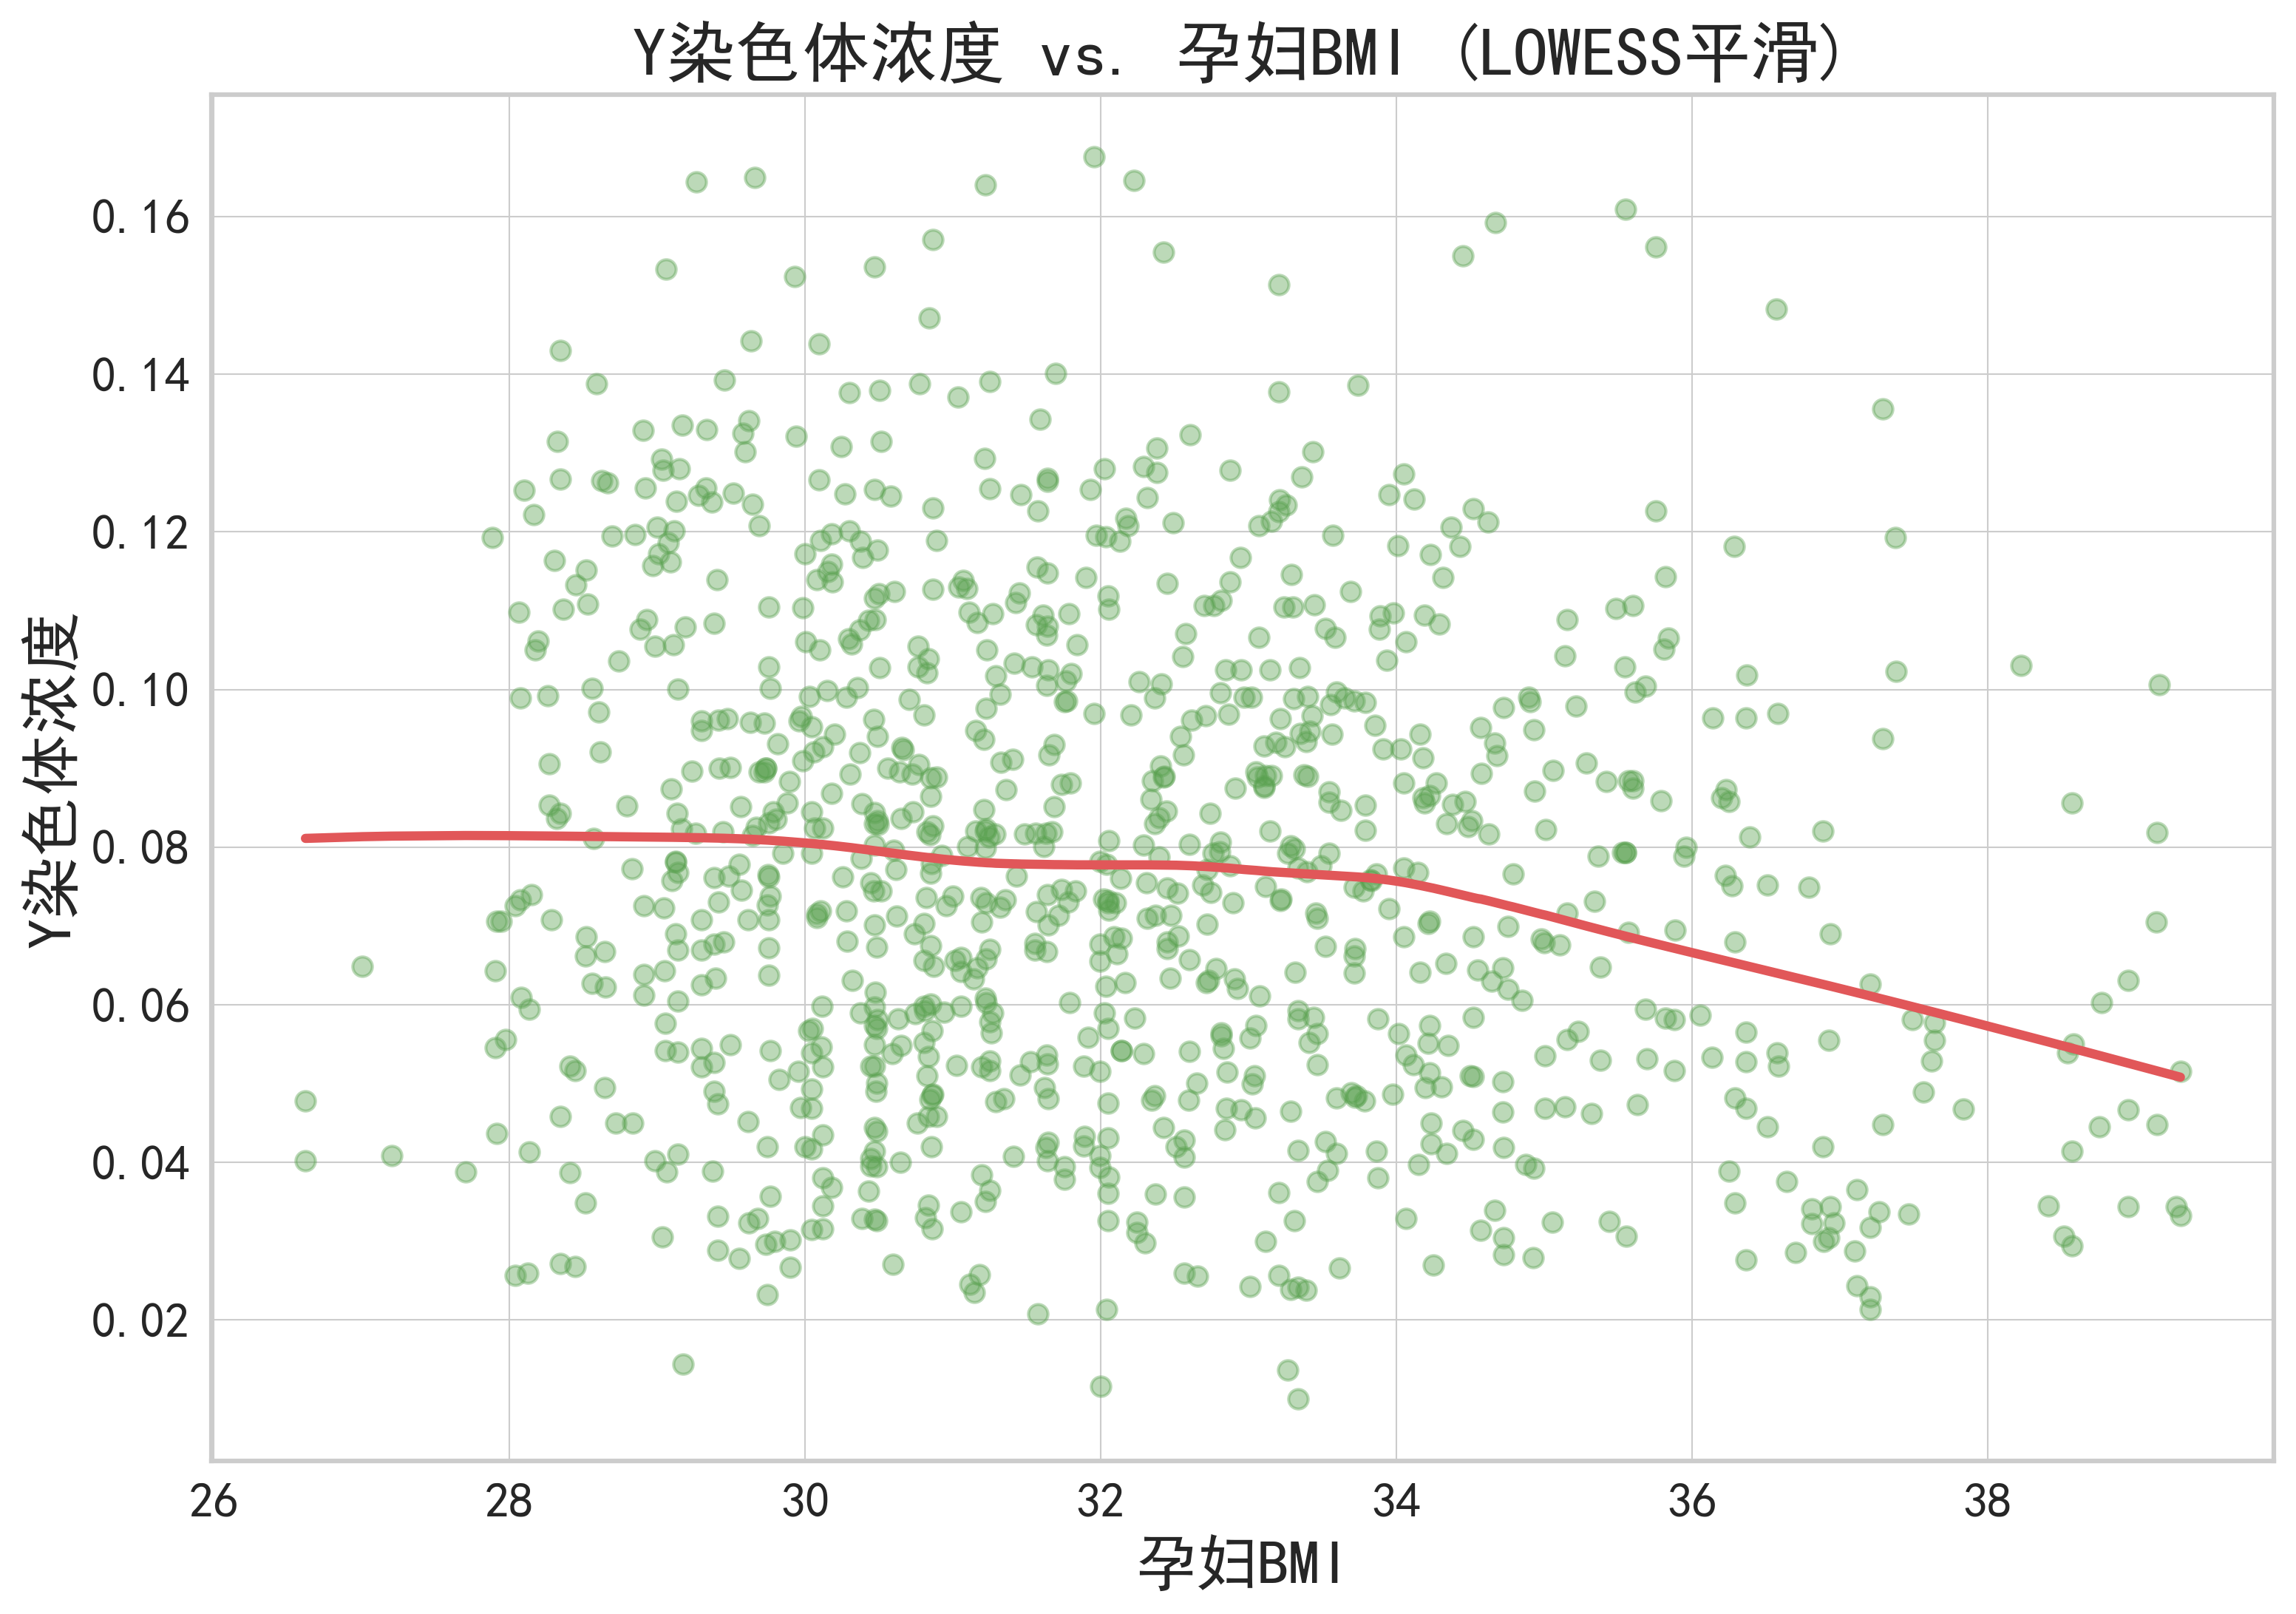

图3 已生成。


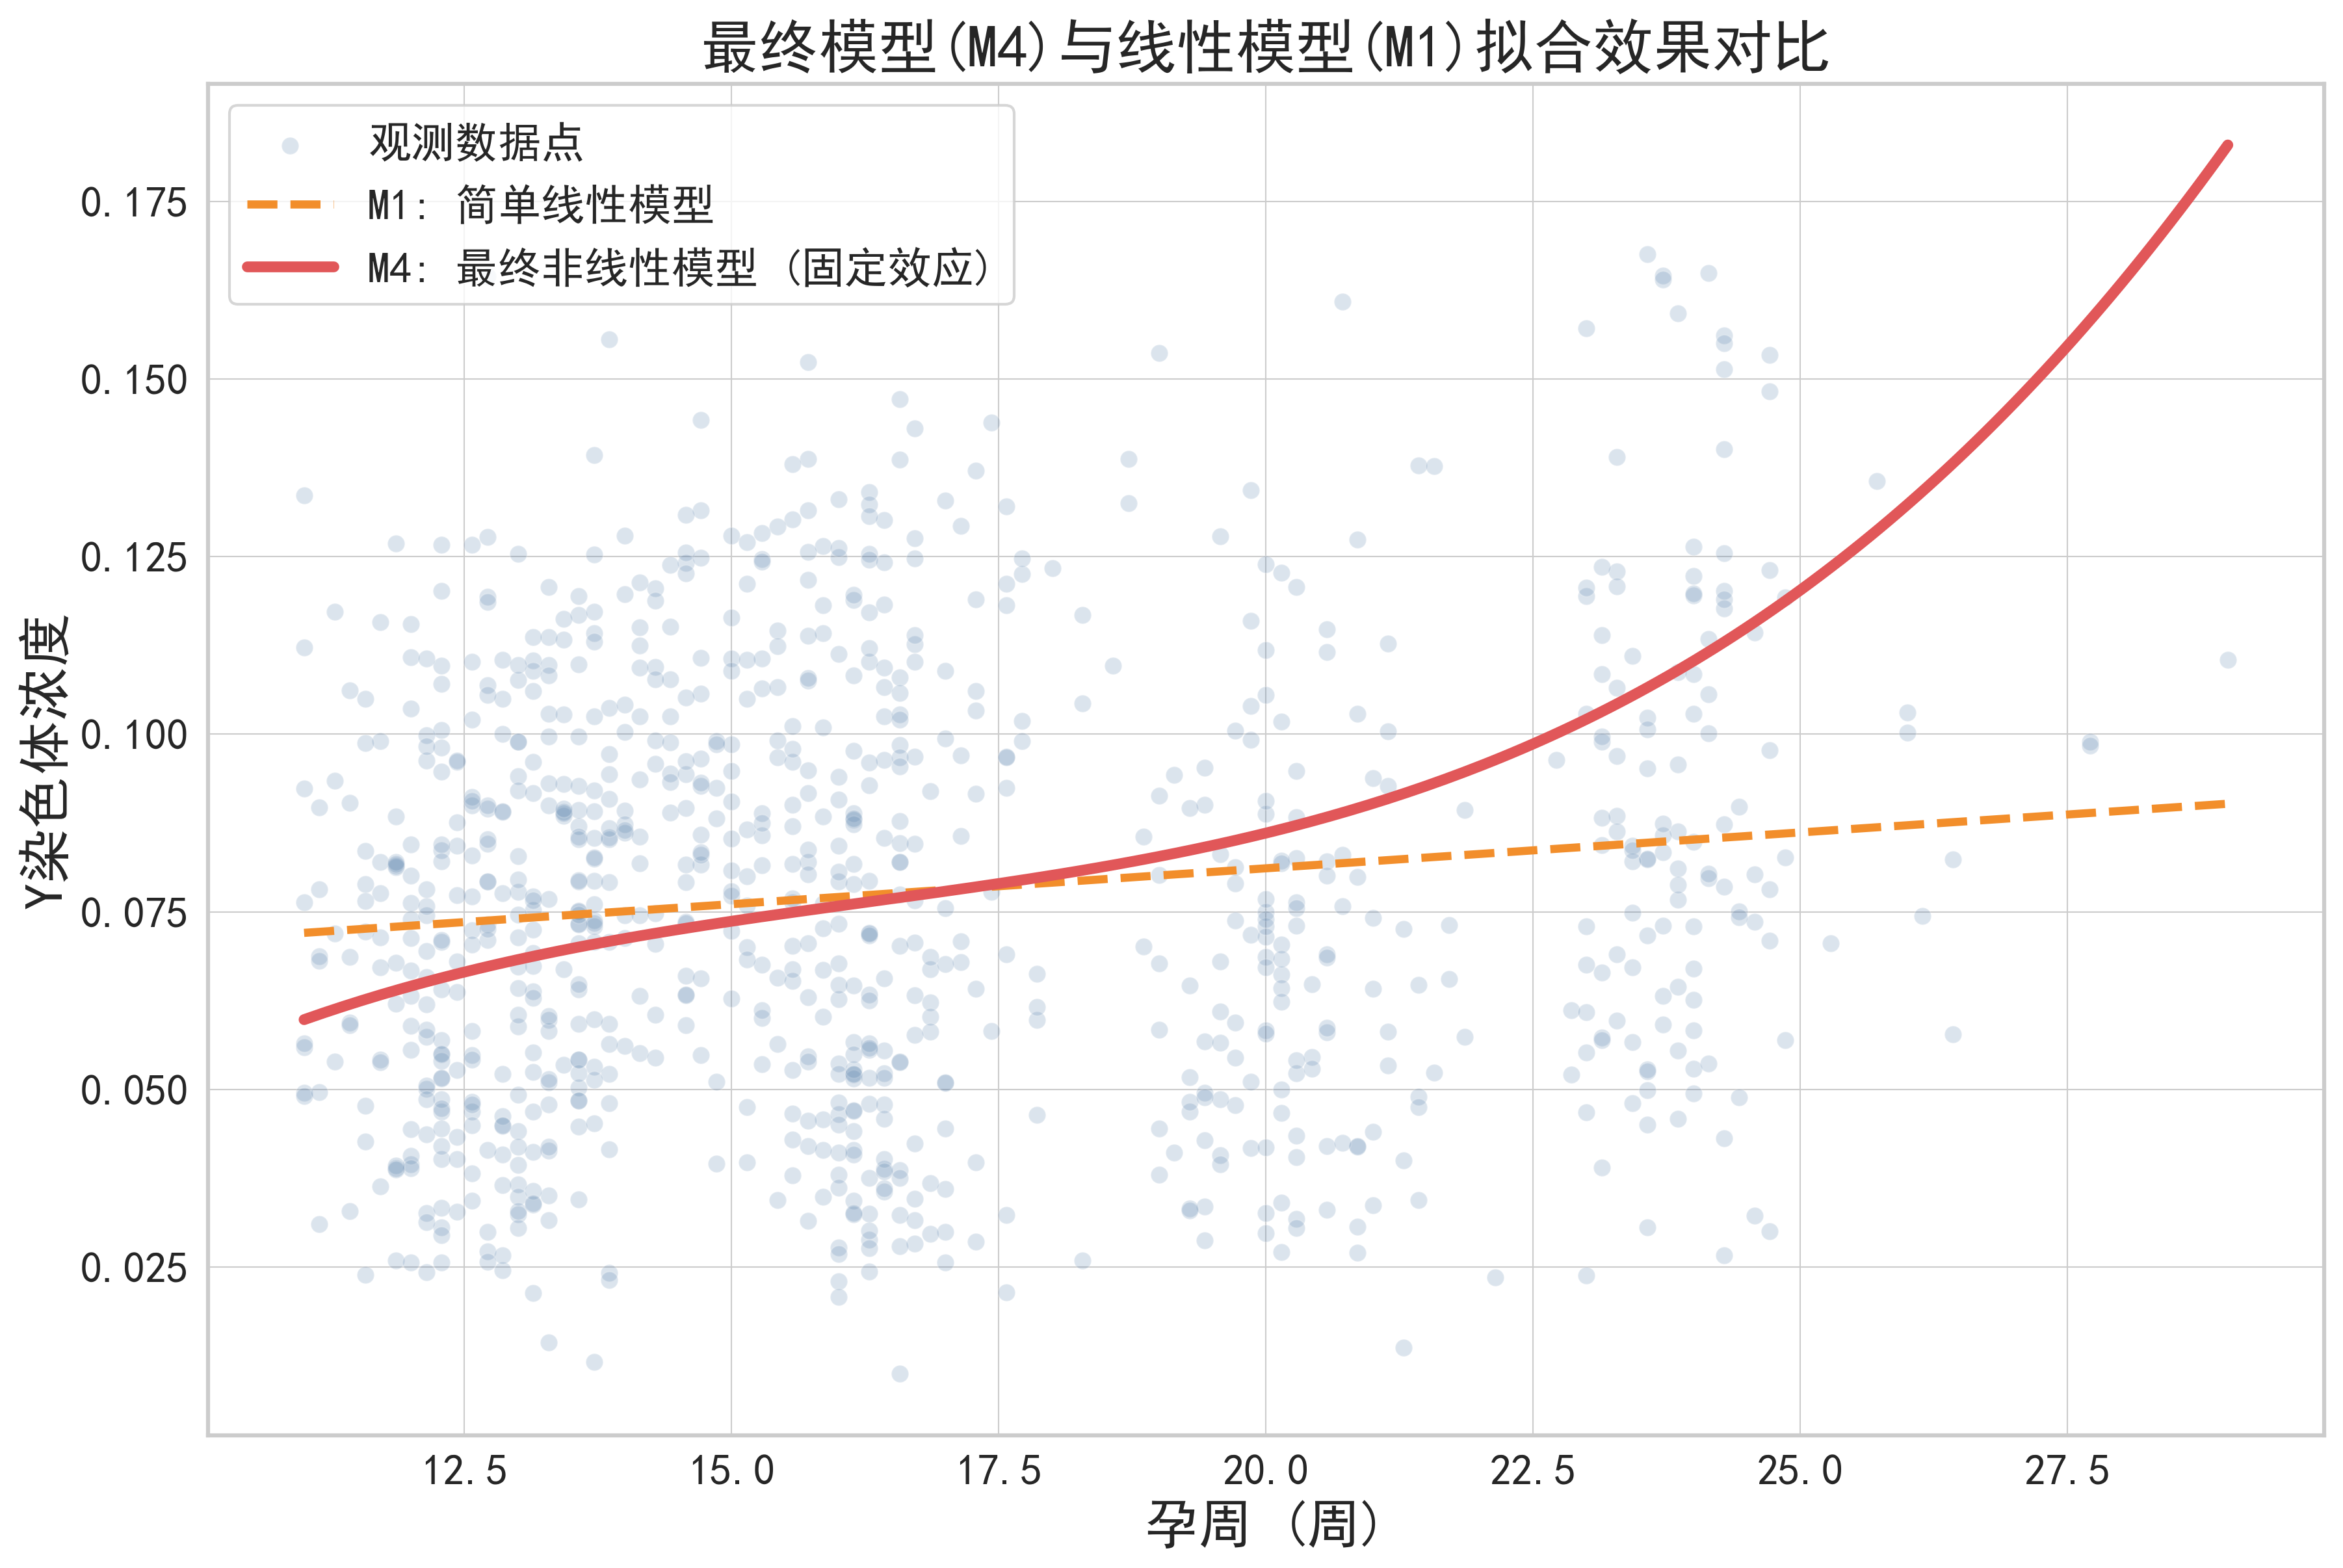

图4 已生成。


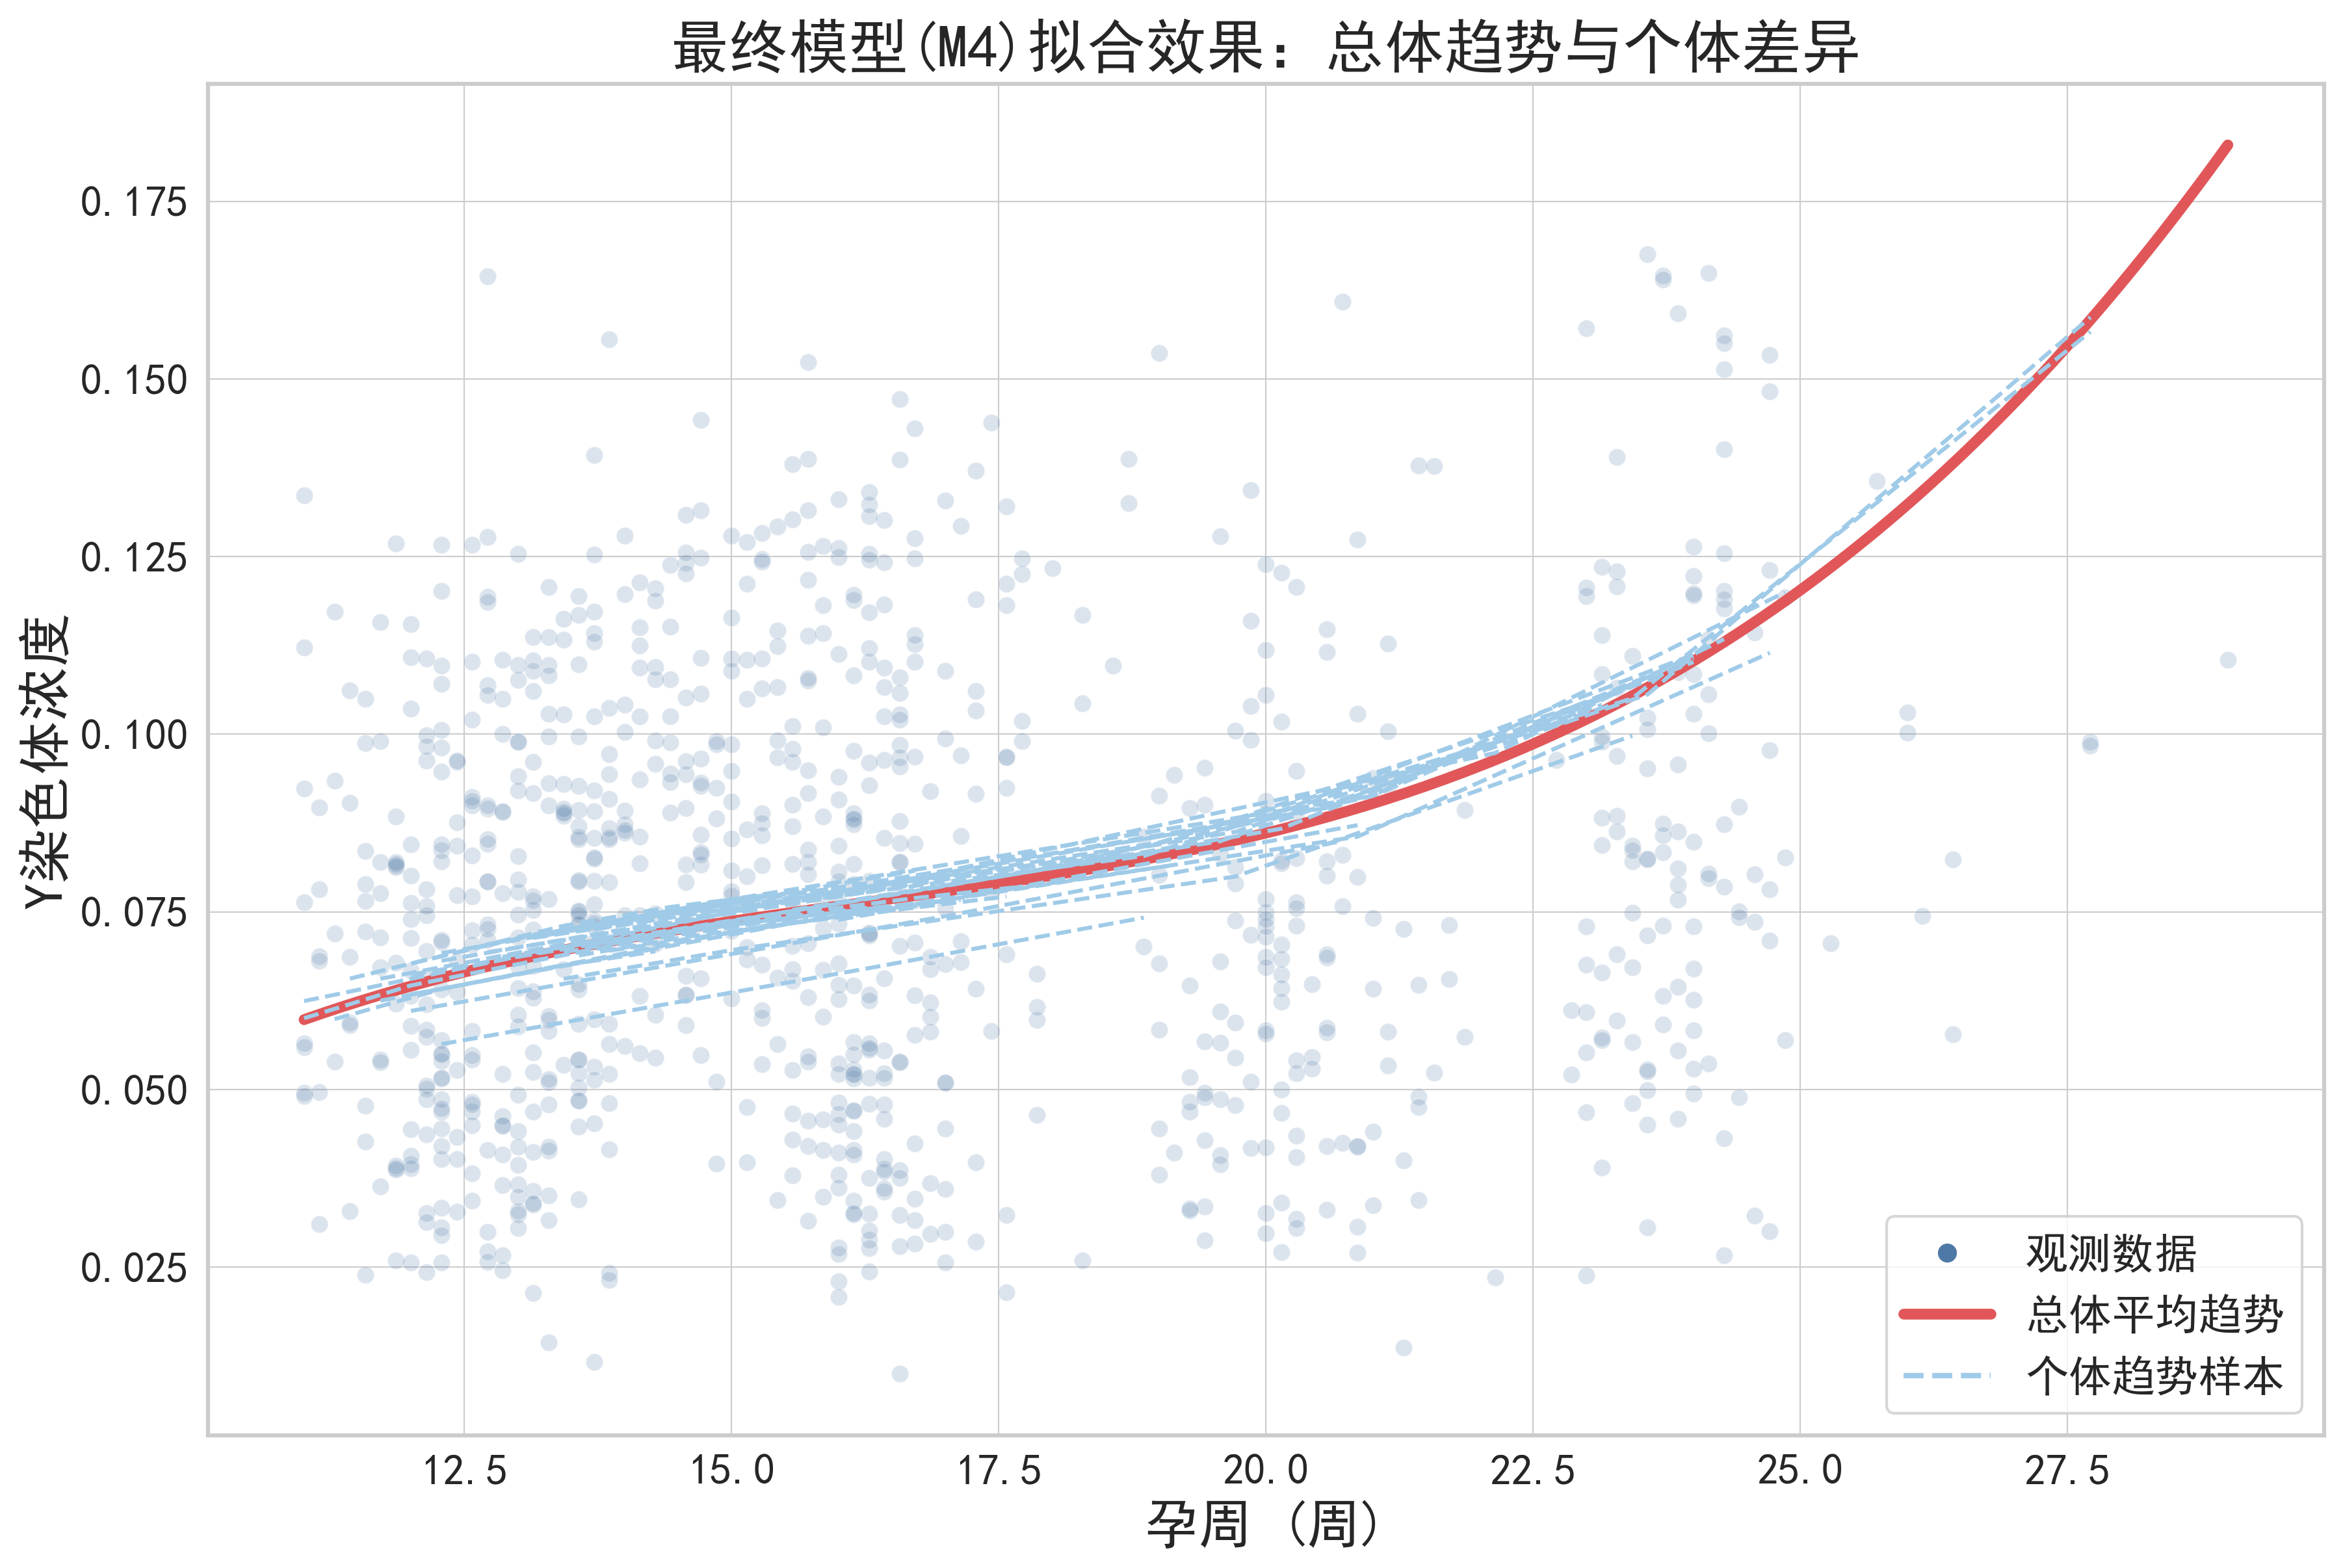

图5 已生成。

--- 问题一的所有可视化任务已完成 ---


In [36]:
import pandas as pd
import numpy as np
import os
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import warnings

def generate_visualizations_q1():
    """
    问题一的可视化脚本：
    读取分析后的数据，重新拟合必要的模型，生成所有最终图表。
    """
    # ==============================================================================
    # Part 0: 环境准备
    # ==============================================================================
    print("--- [Part 0] 环境准备与路径设置 ---")
    warnings.filterwarnings('ignore')

    RESULT_DIR = 'Result'
    IMAGE_DIR = os.path.join(RESULT_DIR, 'Images_Final_Paper')
    os.makedirs(IMAGE_DIR, exist_ok=True)

    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    PALETTE = {
        "scatter_main": "#4E79A7", "scatter_alt1": "#59A14F",
        "line_fit": "#E15759", "outlier": "#F28E2B", 
        "individual_lines": "#A0CBE8", "line_fit_m1": "#F28E2B"
    }
    sns.set_style("whitegrid", {"font.sans-serif": ['SimHei', 'Arial']})
    print(f"所有最终图表将保存至: {IMAGE_DIR}")

    # ==============================================================================
    # Part 1: 数据加载与模型重现
    # ==============================================================================
    print("\n--- [Part 1] 数据加载与模型重现 ---")
    
    try:
        model_data = pd.read_csv(os.path.join(RESULT_DIR, 'final_model_data.csv'))
        male_df = pd.read_csv(os.path.join(RESULT_DIR, 'full_data_with_outlier_tags.csv'))
    except FileNotFoundError:
        print(f"\n错误: 未找到所需数据文件。请先运行脚本一 'run_final_analysis_q1()'。")
        return

    # 为绘图重现必要的模型
    m1_linear = smf.ols('Y染色体浓度 ~ GW + BMI', data=model_data).fit()
    # 注意：这里的公式应该与脚本一发现的最优公式一致
    formula_m4 = 'Y染色体浓度 ~ GW + I(GW**2) + I(GW**3) + I(BMI**3)' 
    m4_final = smf.mixedlm(formula_m4, data=model_data, groups='孕妇代码', re_formula='~ GW').fit(reml=False, method='cg')
    print("绘图所需的模型已重现。")
    
    # ==============================================================================
    # Part 2: 生成所有最终版可视化图表
    # ==============================================================================
    print("\n--- [Part 2] 开始生成所有最终版可视化图表 ---")

    # --- 图1: Y浓度离群点剔除可视化 ---
    plt.figure(figsize=(14, 8))
    male_df['is_outlier_y_cat'] = male_df['Y染色体浓度_is_outlier'].astype(bool)
    sns.histplot(data=male_df, x='Y染色体浓度', hue='is_outlier_y_cat', 
                 palette={False: PALETTE['scatter_main'], True: PALETTE['outlier']}, kde=True, multiple="stack")
    upper_bound_y = male_df['Y染色体浓度'].quantile(0.75) + 1.5 * (male_df['Y染色体浓度'].quantile(0.75) - male_df['Y染色体浓度'].quantile(0.25))
    plt.axvline(x=upper_bound_y, color=PALETTE['line_fit'], linestyle='--', linewidth=2.5)
    handles, labels = plt.gca().get_legend_handles_labels(); n_kept = (~male_df['is_outlier_y_cat']).sum(); n_outlier = male_df['is_outlier_y_cat'].sum()
    plt.legend(handles=handles, labels=[f'保留的数据 (n={n_kept})', f'剔除的数据 (n={n_outlier})'], fontsize=16)
    plt.xlabel('Y染色体浓度', fontsize=20); plt.ylabel('频数', fontsize=20); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title('Y染色体浓度离群点识别', fontsize=22)
    plt.savefig(os.path.join(IMAGE_DIR, '图1_Y浓度离群点剔除可视化.png'), dpi=300, bbox_inches='tight'); plt.show()
    print("图1 已生成。")

    # --- 图2 & 3: 核心变量散点图 (EDA) ---
    chart_counter = 2
    for var, color in {'GW': PALETTE['scatter_main'], 'BMI': PALETTE['scatter_alt1']}.items():
        plt.figure(figsize=(12, 8))
        sns.regplot(data=model_data, x=var, y='Y染色体浓度', scatter_kws={'alpha': 0.4, 'color': color, 's': 40}, line_kws={'color': PALETTE['line_fit'], 'linewidth': 3}, lowess=True)
        var_label = '孕周 (周)' if var == 'GW' else '孕妇BMI'
        plt.xlabel(var_label, fontsize=20); plt.ylabel('Y染色体浓度', fontsize=20); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        plt.title(f'Y染色体浓度 vs. {var_label} (LOWESS平滑)', fontsize=22)
        plt.savefig(os.path.join(IMAGE_DIR, f'图{chart_counter}_Y浓度_vs_{var}_散点图.png'), dpi=300, bbox_inches='tight'); plt.show()
        print(f"图{chart_counter} 已生成。")
        chart_counter += 1
        
    # --- 图4: M1 vs M4 模型拟合效果对比图 ---
    plt.figure(figsize=(14, 9))
    gw_range = np.linspace(model_data['GW'].min(), model_data['GW'].max(), 200)
    plot_df = pd.DataFrame({'GW': gw_range, 'BMI': model_data['BMI'].mean()})
    pred_m1 = m1_linear.predict(plot_df)
    pred_m4 = m4_final.predict(plot_df)
    sns.scatterplot(data=model_data, x='GW', y='Y染色体浓度', color=PALETTE['scatter_main'], alpha=0.2, s=40, label='观测数据点')
    plt.plot(plot_df['GW'], pred_m1, color=PALETTE['line_fit_m1'], linewidth=3, linestyle='--', label='M1: 简单线性模型')
    plt.plot(plot_df['GW'], pred_m4, color=PALETTE['line_fit'], linewidth=4, linestyle='-', label='M4: 最终非线性模型 (固定效应)')
    plt.xlabel('孕周 (周)', fontsize=20); plt.ylabel('Y染色体浓度', fontsize=20); plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.legend(fontsize=16)
    plt.title('最终模型(M4)与线性模型(M1)拟合效果对比', fontsize=22)
    plt.savefig(os.path.join(IMAGE_DIR, '图4_模型拟合效果对比图.png'), dpi=300, bbox_inches='tight'); plt.show()
    print("图4 已生成。")
    
    # --- 图5: 最终模型M4的可视化图 ---
    plt.figure(figsize=(14, 9))
    sns.scatterplot(data=model_data, x='GW', y='Y染色体浓度', color=PALETTE['scatter_main'], alpha=0.2, s=40)
    plt.plot(gw_range, pred_m4, color=PALETTE['line_fit'], linewidth=4, linestyle='-')
    np.random.seed(42)
    random_subjects = np.random.choice(model_data['孕妇代码'].unique(), 30, replace=False)
    for subject in random_subjects:
        subject_data = model_data[model_data['孕妇代码'] == subject].sort_values('GW')
        y_ind_trend = m4_final.predict(subject_data)
        plt.plot(subject_data['GW'], y_ind_trend, color=PALETTE['individual_lines'], linewidth=1.5, linestyle='--')
    
    custom_lines = [Line2D([0], [0], color=PALETTE['scatter_main'], marker='o', linestyle='None'), Line2D([0], [0], color=PALETTE['line_fit'], lw=4), Line2D([0], [0], color=PALETTE['individual_lines'], lw=2, ls='--')]
    plt.legend(custom_lines, ['观测数据', '总体平均趋势', '个体趋势样本'], fontsize=16)
    plt.xlabel('孕周 (周)', fontsize=20); plt.ylabel('Y染色体浓度', fontsize=20); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title('最终模型(M4)拟合效果：总体趋势与个体差异', fontsize=22)
    plt.savefig(os.path.join(IMAGE_DIR, '图5_最终模型M4_可视化.png'), dpi=300, bbox_inches='tight'); plt.show()
    print("图5 已生成。")

    print("\n--- 问题一的所有可视化任务已完成 ---")

if __name__ == "__main__":
    generate_visualizations_q1()